## Data Clustering

In this personal project I studied the electricity demand from clients in Portugal, during 2013 and 2014. The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

* Explore a dataset and carry out clustering using k-means algorithm

* Identify the optimum number of clusters for a given dataset

Data

1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm

## Data Preparation


In [1]:
#pathToFile = r"C:\\path\\to\\file\\"
pathToFile = r"C:\\Users\\Natalia Restrepo\\Downloads\\"

fileName = 'LD2011_2014.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [3]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [5]:
data.columns

Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_361', 'MT_362', 'MT_363', 'MT_364', 'MT_365', 'MT_366', 'MT_367',
       'MT_368', 'MT_369', 'MT_370'],
      dtype='object', length=370)

In [6]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [8]:
data.shape

(140256, 370)

#### As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [10]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plotting the first 2 days of 2012 for the first 2 clients

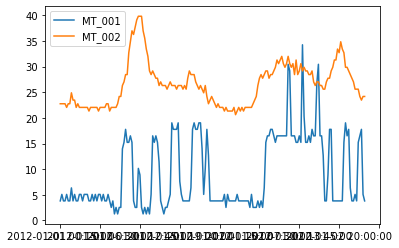

In [11]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We  note that the main difference between the curves is the level (also seen on the means in df.describe()).  We know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with low number of clients having zero demand

In [12]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [13]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [14]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [15]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [16]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [17]:
data['hour'] = data.index.map(lambda x: x[11:]) #we are basically erasing the date from the index = taking only the hour

In [18]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [19]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

In [20]:
average_curves #grouped by hour and calculate the mean for every hour in each day of year 2013 and 2014

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
00:00:00,5.008344,26.045909,1.938755,130.551843,60.374206,191.136660,7.772366,242.027582,51.585401,54.837237,...,119.625903,36306.438356,1333.223513,1652.677460,37.831080,16.499275,676.790504,148.683880,799.235729,17333.891151
00:15:00,4.917947,25.833512,1.911381,125.863125,57.586034,179.297130,7.426996,232.516950,50.016764,53.424658,...,119.540837,32137.534247,979.064794,1443.711083,33.942955,16.580232,659.875882,155.464587,795.100028,17466.227323
00:30:00,4.984007,24.754964,1.909001,121.566990,55.476111,171.554958,7.179972,225.317098,48.843280,52.514361,...,111.557303,27249.178082,938.598925,1324.501868,31.044275,15.940589,655.911819,153.879754,777.630258,17605.301740
00:45:00,4.980530,24.656560,1.899480,117.961354,53.630137,164.452870,7.013482,218.698400,47.574001,51.150390,...,97.361963,24234.109589,837.292642,1134.433375,30.245932,15.121396,644.171167,151.146889,769.361869,17589.559422
01:00:00,4.963146,23.665699,1.863775,111.732932,52.123288,155.850457,6.843894,212.291868,46.570553,50.223892,...,91.873711,20504.383562,812.213167,1110.118306,29.617260,15.693709,640.233562,148.288243,763.943679,17574.838949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45:00,5.175231,26.859448,2.029206,154.276646,69.679252,241.809361,8.759689,282.270190,60.855925,63.423185,...,214.890538,58302.328767,2422.484249,3540.815691,104.439999,17.210257,704.703718,153.067899,825.106456,17683.613476
23:00:00,5.319519,26.919854,1.973269,148.123399,68.810558,234.515656,8.617205,275.485448,59.574672,62.060686,...,186.405014,52881.095890,2283.053003,3428.486924,97.120966,17.076397,706.203471,150.689505,821.116378,17534.542762
23:15:00,5.356025,26.839962,1.962558,141.869919,67.398931,223.434442,8.373278,267.040266,57.366606,59.584622,...,164.177251,47958.219178,2119.206982,2913.449564,82.870461,16.923299,697.439475,149.175567,827.424376,17311.010737


#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [21]:
average_curves_norm = average_curves/(average_curves.mean())

In [22]:
average_curves_norm

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,...,0.414676,0.748555,0.561491,0.430085,0.471574,1.358632,1.215272,1.170441,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,...,0.414381,0.662602,0.412336,0.375704,0.423108,1.365299,1.184899,1.223818,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,...,0.386706,0.561815,0.395294,0.344682,0.386975,1.312627,1.177781,1.211343,0.947969,1.008515
00:45:00,0.959434,0.877243,0.971708,1.030153,1.053960,0.868064,1.056382,0.855331,0.907404,0.885073,...,0.337499,0.499651,0.352628,0.295219,0.377024,1.245171,1.156699,1.189829,0.937889,1.007613
01:00:00,0.956085,0.841989,0.953443,0.975761,1.024347,0.822656,1.030838,0.830275,0.888265,0.869041,...,0.318475,0.422753,0.342066,0.288892,0.369187,1.292298,1.149629,1.167326,0.931284,1.006770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45:00,0.996941,0.955618,1.038072,1.347294,1.369364,1.276390,1.319398,1.103961,1.160737,1.097433,...,0.744905,1.202059,1.020236,0.921445,1.301872,1.417178,1.265394,1.204952,1.005845,1.013001
23:00:00,1.024736,0.957767,1.009456,1.293558,1.352292,1.237890,1.297937,1.077426,1.136299,1.073857,...,0.646161,1.090286,0.961514,0.892213,1.210639,1.406155,1.268087,1.186229,1.000981,1.004462
23:15:00,1.031768,0.954925,1.003976,1.238946,1.324550,1.179398,1.261197,1.044397,1.094183,1.031013,...,0.569110,0.988787,0.892510,0.758182,1.033002,1.393548,1.252350,1.174311,1.008670,0.991657


#### Plotting the first 2 and last 2 clients

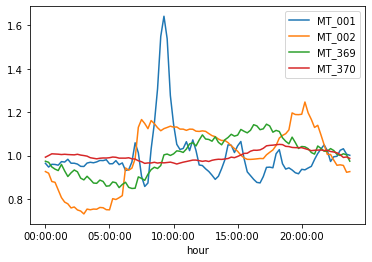

In [23]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normalized curves

In [24]:
X = average_curves_norm.copy()  # We call this normalized curve
X = np.array(X.T) # put it on the right format (transposing)

**Q2: (8 marks)**

In this exercise you work with the daily curves of 1 single client.
First, create a list of arrays, each array containing a curve for a day. You may use X from the cells above.
    X = average_curves_norm.copy() 
The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value of k ( number of clusters). This time you may also perform silhoutte analysis as stated in the module. Carrying out silhoutte analysis is left as an exercise. What do you understand about the clusters? 

b. Based on your results from your analyses of both methods, what do understand?  Interpret it perhaps with different perspectives of timelines like weeks or months.

 Generating a list of all the days in the two years 2013-2014.


In [25]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

### Determining the most convenient number of clusters.

In [27]:
X = average_curves_norm.copy()
X = np.array(X.T)

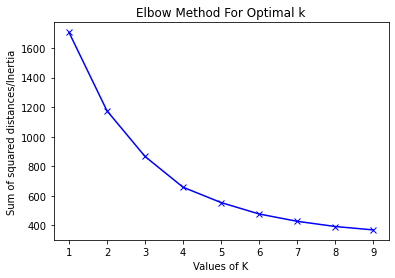

In [28]:
Sum_of_squared_distances = []
K = range(1,10)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow looks grah shows a change is the sum of squared distances (falls suddenly) around 4 or 5, indicating the optimal k for this dataset could be 4 or 5. We will use the Silhouette analysis to determine the optimal k for this dataset

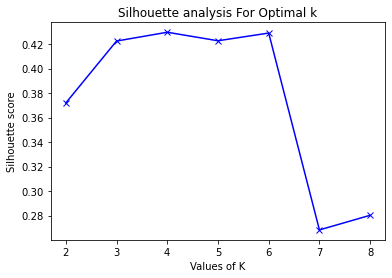

In [29]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(X, cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

We see that the silhouette score is maximized at k = 5. So, we will take 5 clusters.

### Plotting each cluster

In [30]:
df = average_curves_norm.T

In [31]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df)
cluster = kmeans.fit_predict(df)

In [32]:
df['Cluster'] = cluster
df.head()

hour,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00,Cluster
MT_001,0.964792,0.947378,0.960104,0.959434,0.956085,0.972494,0.970485,0.983211,0.965127,0.965127,...,1.049852,1.022727,0.973164,0.994931,0.996941,1.024736,1.031768,1.006652,1.001629,1
MT_002,0.926674,0.919117,0.880744,0.877243,0.841989,0.806701,0.786076,0.778034,0.759108,0.763579,...,1.049731,1.005708,1.005500,0.979363,0.955618,0.957767,0.954925,0.923346,0.926570,1
MT_003,0.991800,0.977796,0.976579,0.971708,0.953443,0.949181,0.954660,0.947354,0.918739,0.925436,...,1.101391,1.092867,1.081908,1.069122,1.038072,1.009456,1.003976,0.998497,0.993017,1
MT_004,1.140106,1.099159,1.061641,1.030153,0.975761,0.920906,0.897345,0.875850,0.855450,0.836217,...,1.495640,1.462960,1.422622,1.389845,1.347294,1.293558,1.238946,1.209744,1.175290,1
MT_005,1.186498,1.131703,1.090238,1.053960,1.024347,0.992994,0.962757,0.934785,0.918994,0.903958,...,1.376127,1.382463,1.388340,1.385878,1.369364,1.352292,1.324550,1.272842,1.231541,1


In [33]:
cluster_k0 = df[df.Cluster == 0].T
cluster_k1 = df[df.Cluster == 1].T
cluster_k2 = df[df.Cluster == 2].T
cluster_k3 = df[df.Cluster == 3].T
cluster_k4 = df[df.Cluster == 4].T

In [34]:
cluster_k0.drop('Cluster',inplace=True)
cluster_k1.drop('Cluster',inplace=True)
cluster_k2.drop('Cluster',inplace=True)
cluster_k3.drop('Cluster',inplace=True)
cluster_k4.drop('Cluster',inplace=True)

Cluster k=0

In [35]:
centroid_0 = pd.DataFrame()
centroid_0['hour'] = cluster_k0.index.values
centroid_0['centroid']=kmeans.cluster_centers_[0]
print('The number of clients in cluster k=0 is', len(cluster_k0.columns))

The number of clients in cluster k=0 is 201


Text(0, 0.5, 'Power consumption (avg)')

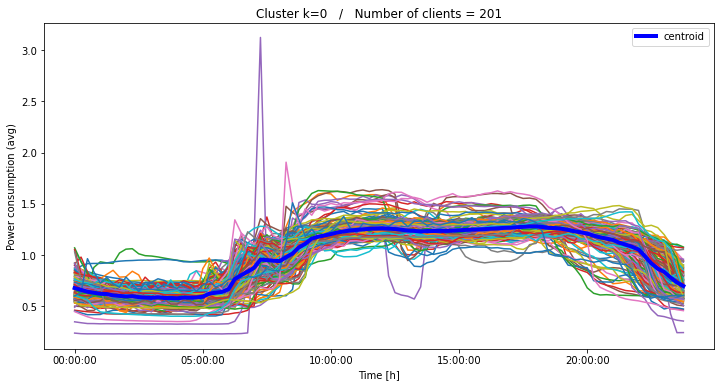

In [36]:
fig, ax = plt.subplots()
cluster_k0.loc[cluster_k0.index.values].plot(ax=ax, figsize=(12,6), legend=False)
centroid_0.plot(ax=ax, figsize=(12,6), color='blue', linewidth=4)
ax.set_title('Cluster k=0   /   Number of clients = 201')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Power consumption (avg)')

Cluster k=1

In [37]:
centroid_1 = pd.DataFrame()
centroid_1['hour'] = cluster_k1.index.values
centroid_1['centroid']=kmeans.cluster_centers_[1]
print('The number of clients in cluster k=1 is', len(cluster_k1.columns))

The number of clients in cluster k=1 is 109


Text(0, 0.5, 'Power consumption (avg)')

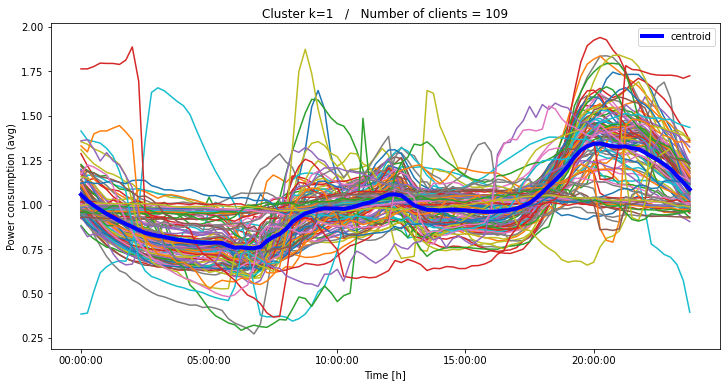

In [38]:
fig, ax = plt.subplots()
cluster_k1.loc[cluster_k1.index.values].plot(ax=ax, figsize=(12,6), legend=False)
centroid_1.plot(ax=ax, figsize=(12,6), color='blue', linewidth=4)
ax.set_title('Cluster k=1   /   Number of clients = 109')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Power consumption (avg)')

Cluster k=2

In [39]:
centroid_2 = pd.DataFrame()
centroid_2['hour'] = cluster_k2.index.values
centroid_2['centroid']=kmeans.cluster_centers_[2]
print('The number of clients in cluster k=2 is', len(cluster_k2.columns))

The number of clients in cluster k=2 is 34


Text(0, 0.5, 'Power consumption (avg)')

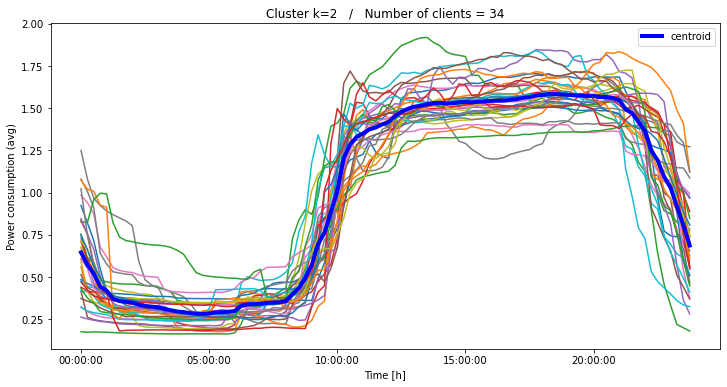

In [40]:
fig, ax = plt.subplots()
cluster_k2.loc[cluster_k2.index.values].plot(ax=ax, figsize=(12,6), legend=False)
centroid_2.plot(ax=ax, figsize=(12,6), color='blue', linewidth=4)
ax.set_title('Cluster k=2   /   Number of clients = 34')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Power consumption (avg)')

Cluster k=3

In [41]:
centroid_3 = pd.DataFrame()
centroid_3['hour'] = cluster_k3.index.values
centroid_3['centroid']=kmeans.cluster_centers_[3]
print('The number of clients in cluster k=3 is', len(cluster_k3.columns))

The number of clients in cluster k=3 is 1


Text(0, 0.5, 'Power consumption (avg)')

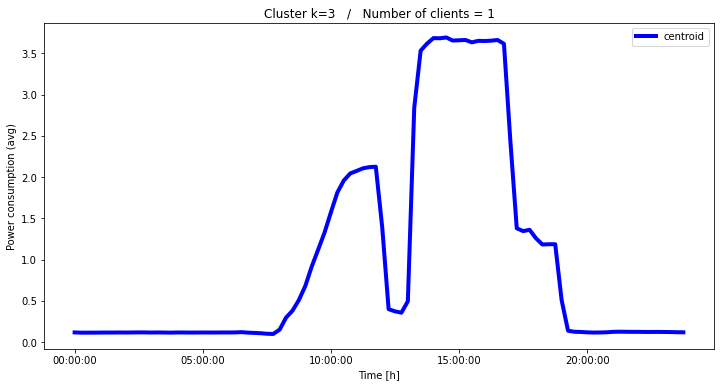

In [42]:
fig, ax = plt.subplots()
cluster_k3.loc[cluster_k3.index.values].plot(ax=ax, figsize=(12,6), legend=False)
centroid_3.plot(ax=ax, figsize=(12,6), color='blue', linewidth=4)
ax.set_title('Cluster k=3   /   Number of clients = 1')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Power consumption (avg)')

Cluster k=4

In [43]:
centroid_4 = pd.DataFrame()
centroid_4['hour'] = cluster_k4.index.values
centroid_4['centroid']=kmeans.cluster_centers_[4]
print('The number of clients in cluster k=4 is', len(cluster_k4.columns))

The number of clients in cluster k=4 is 4


Text(0, 0.5, 'Power consumption (avg)')

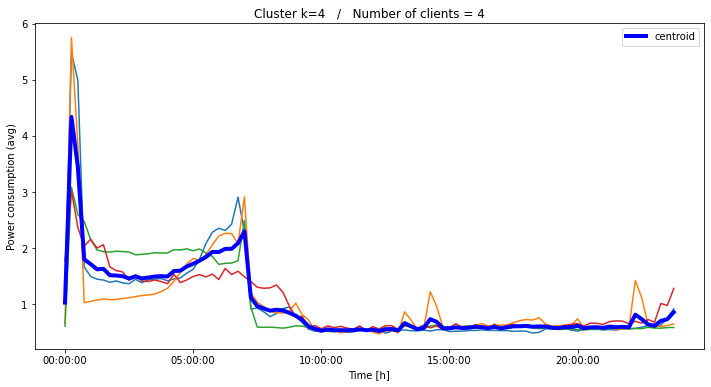

In [44]:
fig, ax = plt.subplots()
cluster_k4.loc[cluster_k4.index.values].plot(ax=ax, figsize=(12,6), legend=False)
centroid_4.plot(ax=ax, figsize=(12,6), color='blue', linewidth=4)
ax.set_title('Cluster k=4   /   Number of clients = 4')
ax.set_xlabel('Time [h]')
ax.set_ylabel('Power consumption (avg)')

I find weird that our cluster with k=3 has only one client. I'm not sure why nor what could have been my error

### Determining the optimal value of k

In [45]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

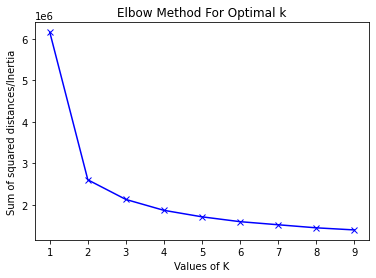

In [46]:
Sum_of_squared_distances = []
K = range(1,10)

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In this case, we observe that the  change in the sum of squared distances is at k=2. 

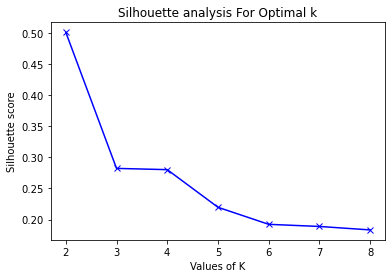

In [47]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(X, cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

With the silhouette analysis we can observe clearly that the score is maximized at k = 2.

### Generating  timelines 

In [48]:
len(X)

730

In [49]:
df2 = pd.DataFrame(X)
df2['day of year']=daysyear
df2.set_index('day of year',inplace=True)

columns_name = average_curves_norm.index.values
df2.columns=columns_name
df2

,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
day of year,,,,,,,,,,,,,,,,,,,,,
tue-2013-01-01,31.133250,28.642590,27.397260,24.906600,24.283935,26.151930,26.151930,24.906600,26.774595,23.661270,...,31.133250,28.019925,26.774595,26.774595,24.906600,26.151930,27.397260,26.774595,23.661270,24.283935
wed-2013-01-02,22.415940,22.415940,20.547945,20.547945,22.415940,21.793275,19.925280,23.038605,20.547945,21.170610,...,29.265255,28.642590,26.774595,28.642590,26.774595,24.906600,23.038605,23.038605,23.661270,24.283935
thu-2013-01-03,21.793275,21.170610,20.547945,19.925280,19.302615,20.547945,18.057285,18.679950,18.057285,17.434620,...,31.755915,31.755915,32.378580,33.001245,29.265255,26.774595,28.019925,26.774595,28.019925,26.151930
fri-2013-01-04,23.661270,22.415940,22.415940,21.793275,22.415940,20.547945,21.170610,21.170610,21.793275,21.793275,...,30.510585,27.397260,28.019925,27.397260,28.019925,26.774595,29.887920,28.642590,26.774595,24.906600
sat-2013-01-05,19.925280,19.302615,19.925280,19.302615,18.057285,18.679950,18.057285,18.057285,18.057285,19.302615,...,33.623910,33.001245,27.397260,27.397260,30.510585,29.265255,29.887920,30.510585,26.151930,28.019925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sat-2014-12-27,21.170610,21.793275,21.170610,20.547945,21.793275,21.170610,19.925280,19.925280,19.925280,19.302615,...,37.982565,38.605230,36.114570,37.982565,37.359900,36.114570,37.359900,35.491905,32.378580,28.642590
sun-2014-12-28,31.133250,29.265255,28.019925,28.019925,26.151930,24.906600,24.906600,25.529265,25.529265,25.529265,...,39.850560,38.605230,37.982565,32.378580,32.378580,29.887920,33.001245,33.623910,29.887920,26.151930
mon-2014-12-29,28.642590,29.887920,27.397260,28.642590,26.774595,26.151930,26.774595,26.151930,26.774595,25.529265,...,36.114570,34.246575,31.755915,31.133250,33.001245,33.001245,36.114570,36.114570,32.378580,29.887920


In [50]:
kmeans2 = KMeans(n_clusters=5, random_state=0).fit(df2)
cluster = kmeans2.fit_predict(df2)
df2['Cluster'] = cluster
df2.head()

,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00,Cluster
day of year,,,,,,,,,,,,,,,,,,,,,
tue-2013-01-01,31.133250,28.642590,27.397260,24.906600,24.283935,26.151930,26.151930,24.906600,26.774595,23.661270,...,28.019925,26.774595,26.774595,24.906600,26.151930,27.397260,26.774595,23.661270,24.283935,0
wed-2013-01-02,22.415940,22.415940,20.547945,20.547945,22.415940,21.793275,19.925280,23.038605,20.547945,21.170610,...,28.642590,26.774595,28.642590,26.774595,24.906600,23.038605,23.038605,23.661270,24.283935,1
thu-2013-01-03,21.793275,21.170610,20.547945,19.925280,19.302615,20.547945,18.057285,18.679950,18.057285,17.434620,...,31.755915,32.378580,33.001245,29.265255,26.774595,28.019925,26.774595,28.019925,26.151930,1
fri-2013-01-04,23.661270,22.415940,22.415940,21.793275,22.415940,20.547945,21.170610,21.170610,21.793275,21.793275,...,27.397260,28.019925,27.397260,28.019925,26.774595,29.887920,28.642590,26.774595,24.906600,1
sat-2013-01-05,19.925280,19.302615,19.925280,19.302615,18.057285,18.679950,18.057285,18.057285,18.057285,19.302615,...,33.001245,27.397260,27.397260,30.510585,29.265255,29.887920,30.510585,26.151930,28.019925,0


In [51]:
cluster_k0_df2 = df2[df2.Cluster == 0]
cluster_k1_df2 = df2[df2.Cluster == 1]

cluster_k0_df2 = cluster_k0_df2.drop('Cluster', axis=1)
cluster_k1_df2 = cluster_k1_df2.drop('Cluster', axis=1)


In [63]:
print(" The number of client in cluster K=0 is: ",len(cluster_k0_df2),'\n',"The number of clients in cluster k-1 is: ",len(cluster_k1_df2))

 The number of client in cluster K=0 is:  83 
 The number of clients in cluster k-1 is:  221


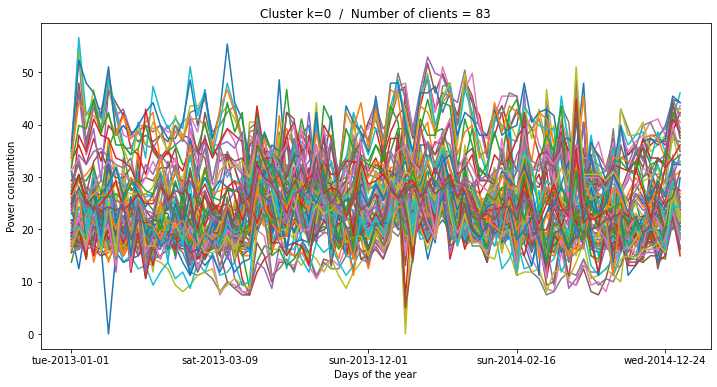

In [64]:
cluster_k0_df2.plot(figsize=(12,6), legend=False)
plt.xlabel('Days of the year') 
plt.ylabel('Power consumtion') 
plt.title('Cluster k=0  /  Number of clients = 83')
plt.show()

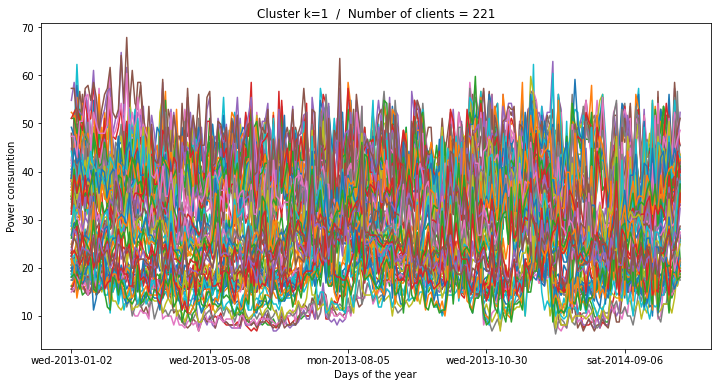

In [65]:
cluster_k1_df2.plot(figsize=(12,6), legend=False)
plt.xlabel('Days of the year') 
plt.ylabel('Power consumtion') 
plt.title('Cluster k=1  /  Number of clients = 221')
plt.show()

Conclusions

- The Elbow and the Silhouette grapsh are useful methods to find the optimal number of clusters when doing a k-means clustering. Nevertheless, we can observe some ambiguity arising for the elbow method when picking the value of k, because sometimes the fall in the average distance is not as clear. In those cases, the Silhouette analysis can be better at finding the optimal number of cluster because it studies the separation distance between the resulting clusters.
- The Silhouette method also has the advantage that allow us to find the outliers if present in a cluster.